In [84]:
import wfdb
import requests, zipfile, io
import pandas as pd
import ast
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [34]:
# download ptb-xl
r = requests.get("https://physionet.org/static/published-projects/ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3.zip")
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall("/tmp/ptbxl")
#TODO YONIGO use extract

In [10]:
ptbxl_root = "/tmp/ptbxl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/"

In [3]:
dd =  pd.read_csv("/tmp/ptbxl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/scp_statements.csv",index_col=0)
diagnosis_mapping = dd.to_dict("index")

In [29]:
df = pd.read_csv("/tmp/ptbxl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/ptbxl_database.csv")
df["scp_codes"] = df["scp_codes"].apply(lambda scp: 
    list(set([diagnosis_mapping[k]["diagnostic_class"] 
     for k in ast.literal_eval(scp).keys() if k in diagnosis_mapping])))
df = df[["ecg_id","patient_id","scp_codes","filename_hr"]]
df["y"] = df["scp_codes"].apply(lambda l: "STTC" in l).astype(np.float32)
df["filename_hr"] = ptbxl_root+df["filename_hr"] 

In [58]:
def read_record(path):
    record = wfdb.rdrecord(path.decode("utf-8"))
    return record.p_signal.astype(np.float32)
    

In [66]:
ds = tf.data.Dataset.from_tensor_slices((df["filename_hr"],df["y"]))
ds = ds.map(lambda x,y : (tf.numpy_function(read_record,inp=[x],Tout=tf.float32),y))
ds = ds.cache()
ds = ds.batch(64)
ds = ds.prefetch(tf.data.AUTOTUNE)

In [75]:
ecg=next(iter(ds))[0][0].numpy()

2022-12-30 12:36:57.898294: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [98]:
def plot_ax(ax, signal, sampling_rate):
    
    
    color_line = (0, 0, 0.7)    
    color_major = (1, 0, 0)
    color_minor = (1, 0.7, 0.7)
    
    signal = signal - (signal.max()+signal.min())/2 # center signal
    ax.plot(np.arange(0,len(signal)),signal,linewidth=0.5,color=color_line)

    # set major grid
    xmajor = np.arange(0,len(signal),sampling_rate*0.2)    
    ymajor = np.arange(-1, 1, 0.5)
    ax.set_xticks(xmajor, minor=False)
    ax.set_xticks(xmajor, minor=False)
    ax.set_yticks(ymajor, minor=False)    
    ax.grid(which="major", color=color_major, linewidth=0.5)
    
    # set minor grid
    xminor = np.arange(0, len(signal), sampling_rate*0.04)
    yminor = np.arange(-1, 1, 0.1)
    ax.set_xticks(xminor, minor=True)
    ax.set_yticks(yminor, minor=True)
    ax.grid(which="minor", color=color_minor, linewidth=0.5)
        
    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])
    
    ax.margins(0)
        
    ax.set_ylim(-1,1)

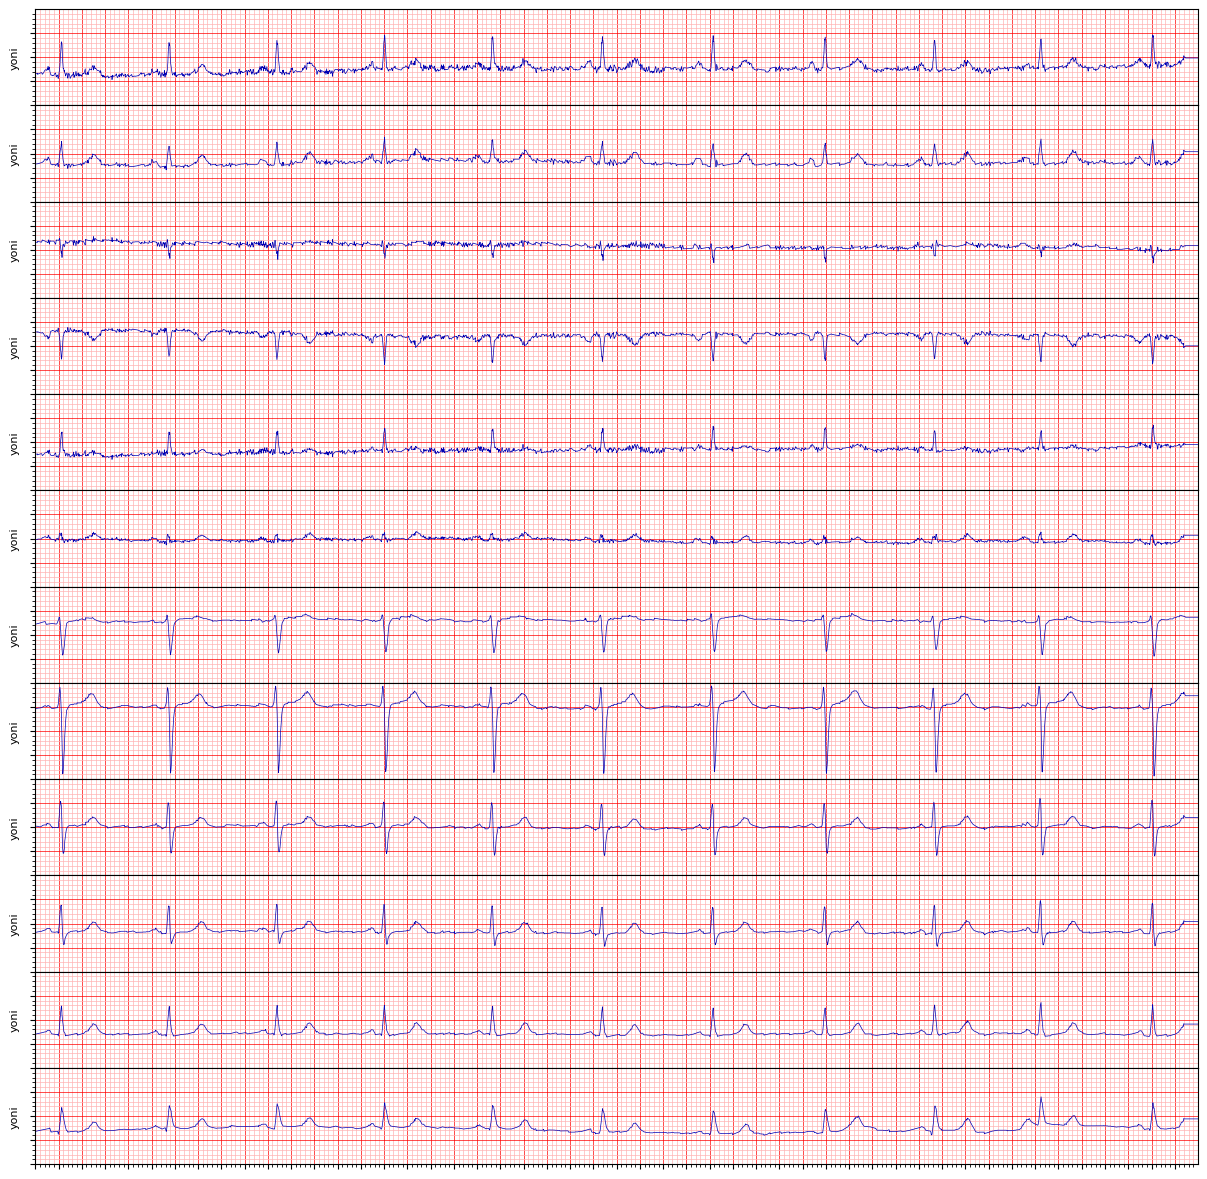

In [102]:
figsize = (15, 15)
lead_index = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
fig,axs = plt.subplots(12,1,figsize=figsize)
fig.subplots_adjust(hspace=0.0)
for i,ax in enumerate(axs):
    plot_ax(ax,ecg[:,i],500)
    ax.set_ylabel("yoni")
    